 ## EuroSAT Land Use and Land Cover Classification using Deep Learning

In this notebook, I implement increasingly complex deep learning models to identify land use and land cover classifications on the [EuroSAT dataset](https://github.com/phelber/eurosat), a collection of 27,000 Sentinel-2 satellite images consisting of 13 spectral bands and 10 pre-labeled classes (e.g., Highway, AnnualCrop, River, Residential).[1][2]

My best overall model, `M_MS`, which uses all 13 bands and a 50% training set, was able to **accurately predict the classification for 94.9% of the testing set.**

My best RGB-only model, `M8`, **accurately classified 94.5% of the testing set** images. However, this model featured a significantly shorter training time, and given that it was trained only on RGB channels, it could be applied to other satellite imagery more easily than `M_MS`, which requires input images to cover the same 13 spectral bands as Sentinel-2 images.

> **[1]** Eurosat: A novel dataset and deep learning benchmark for land use and land cover classification. Patrick Helber, Benjamin Bischke, Andreas Dengel, Damian Borth. IEEE Journal of Selected Topics in Applied Earth Observations and Remote Sensing, 2019.
> 
> **[2]** Introducing EuroSAT: A Novel Dataset and Deep Learning Benchmark for Land Use and Land Cover Classification. Patrick Helber, Benjamin Bischke, Andreas Dengel. 2018 IEEE International Geoscience and Remote Sensing Symposium, 2018.



### Data Prep

- Download data from the Eurosat page: https://github.com/phelber/eurosat

- Split the data into training (50%) and testing sets (50%), stratified on class labels (equal percentage of each class type in train and test sets).

In [0]:
from google.colab import drive
drive.mount('/content/drive')
!pip install rasterio

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
# processing and reading images
import zipfile
import requests
import io
from PIL import Image
from skimage.color import rgb2gray
from keras.preprocessing.image import ImageDataGenerator
import rasterio
from rasterio.plot import show, show_hist

# tensor processing
import numpy as np
import os
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelBinarizer

# plotting
import matplotlib.pyplot as plt
from keras.utils import plot_model

# modeling
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.optimizers import RMSprop
from keras.applications import vgg16
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# evaluation metrics
from sklearn.metrics import classification_report
import pandas as pd

In [0]:
print("Tensorflow version " + tf.__version__)

Tensorflow version 2.2.0-rc2


Download and read RGB EuroSAT images from URL


In [0]:
# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSAT.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

In [0]:
# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".jpg"
txtfiles = [x for x in txtfiles if ".jpg" in x]

In [0]:
# read images to numpy array
XImages = np.zeros([len(txtfiles), 64, 64, 3])

i = 0
for pic in txtfiles:
  XImages[i] = np.asarray(Image.open(z.open(pic))).astype('uint8')/255
  print(i)
  i += 1

del r # clear memory
del z 

Streaming output truncated to the last 5000 lines.
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037
22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22058
22059
22060
22061
22062
22063
22064
22065
22066
22067
22068
22069
22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
2

Get image labels

In [0]:
# Get labels in numpy array as strings
labs = np.empty(len(txtfiles), dtype = 'S20')

i = 0
for label in txtfiles:
  labs[i] = label.split('/')[1]
  i += 1

In [0]:
# change them to integers in alphabetical order
label_names, yLabels = np.unique(labs, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))
print(label_Dict)
np.array(np.unique(yLabels, return_counts=True)).T

{0: b'AnnualCrop', 1: b'Forest', 2: b'HerbaceousVegetation', 3: b'Highway', 4: b'Industrial', 5: b'Pasture', 6: b'PermanentCrop', 7: b'Residential', 8: b'River', 9: b'SeaLake'}


array([[   0, 3000],
       [   1, 3000],
       [   2, 3000],
       [   3, 2500],
       [   4, 2500],
       [   5, 2000],
       [   6, 2500],
       [   7, 3000],
       [   8, 2500],
       [   9, 3000]])

5
b'Pasture'


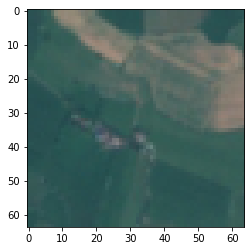

In [0]:
# test that the labels and images read in properly
tmp = 18000
img = XImages[tmp]

print(yLabels[tmp])
print(label_names[yLabels[tmp]])
plt.imshow(img);

Balance the labels

In [0]:
# find the smallest class
smallest_class = np.argmin(np.bincount(yLabels))
smallest_class

5

In [0]:
# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]

# Get 2000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:smallest_class_obs.shape[0]]
  indBal = np.concatenate([indBal, indTemp])

# shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)

In [0]:
yBal = yLabels[indBal]
XBal = XImages[indBal]

print(yBal.shape)
print(XBal.shape)

(20000,)
(20000, 64, 64, 3)


b'River'


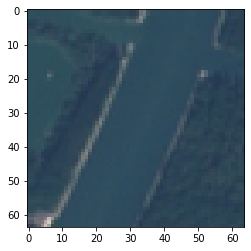

In [0]:
# test that the labels and images are still matched up properly
tmp = 15000
img = XBal[tmp]

print(label_names[yBal[tmp]])
plt.imshow(img);

In [0]:
# first line uses balanced labels
# second line uses original imbalanced labels

# X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(XImages, yLabels, stratify = yLabels, train_size = 0.5, random_state=42)

b'Pasture'


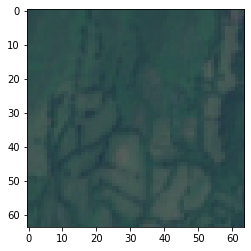

In [0]:
# test that the labels and images are still matched up properly
tmp = 7000
img = X_train[tmp]

print(label_names[y_train[tmp]])
plt.imshow(img);

In [0]:
# class distribution for yTrain
np.array(np.unique(y_train, return_counts=True)).T

array([[   0, 1500],
       [   1, 1500],
       [   2, 1500],
       [   3, 1250],
       [   4, 1250],
       [   5, 1000],
       [   6, 1250],
       [   7, 1500],
       [   8, 1250],
       [   9, 1500]])

In [0]:
# class distribution for yTest
np.array(np.unique(y_test, return_counts=True)).T

array([[   0, 1500],
       [   1, 1500],
       [   2, 1500],
       [   3, 1250],
       [   4, 1250],
       [   5, 1000],
       [   6, 1250],
       [   7, 1500],
       [   8, 1250],
       [   9, 1500]])

In [0]:
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

### First Model

- Convert each RBG image to grayscale and flatten the images into a data matrix (n x p: n = #samples, p = #pixels in each image)

- Implement a first deep learning model `M1` using a fully connected network with a single dense layer. 

- **Classification accuracy on the test data.** 22.0%

This model does not include any spatial information (i.e., pixels don't have any information about neighboring pixels).

In [0]:
# Initialize grayscale arrays
X_train_BW = np.zeros([X_train.shape[0],
                       X_train.shape[1],
                       X_train.shape[2]])

X_test_BW = np.zeros([X_test.shape[0],
                      X_test.shape[1],
                      X_test.shape[2]])

# convert RGB arrays to grayscale
for i in range(X_train.shape[0]):
  X_train_BW[i] = rgb2gray(X_train[i])
  X_test_BW[i] = rgb2gray(X_test[i])

# flatten grayscale arrays
X_train_BW = X_train_BW.reshape(X_train_BW.shape[0],
                                X_train_BW.shape[1] * X_train_BW.shape[2])

X_test_BW = X_test_BW.reshape(X_test_BW.shape[0],
                              X_test_BW.shape[1] * X_test_BW.shape[2])

In [0]:
print("X_train_BW shape:" + str(X_train_BW.shape))
print("X_test_BW shape:" + str(X_test_BW.shape))
print("y_train shape:" + str(y_train.shape))
print("y_test shape:" + str(y_test.shape))

X_train_BW shape:(13500, 4096)
X_test_BW shape:(13500, 4096)
y_train shape:(13500, 10)
y_test shape:(13500, 10)


Implement first deep learning model

In [0]:
# save model to here
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M1.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M1 = Sequential()
M1.add(Dense(num_classes, activation='softmax', input_shape=(4096,)))

M1.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 10)                40970     
Total params: 40,970
Trainable params: 40,970
Non-trainable params: 0
_________________________________________________________________


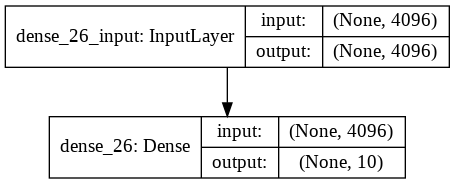

In [0]:
plot_model(M1, show_shapes=True, show_layer_names=True)

In [0]:
M1.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
batch_size = 64
epochs = 100

In [0]:
history = M1.fit(X_train_BW, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    callbacks = callback_list,
                    validation_data=(X_test_BW, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/100
13500/13500 [==============================] - 1s 90us/step - loss: 2.6477 - accuracy: 0.1194 - val_loss: 2.5664 - val_accuracy: 0.1210
Epoch 2/100
13500/13500 [==============================] - 1s 87us/step - loss: 2.5438 - accuracy: 0.1344 - val_loss: 2.5050 - val_accuracy: 0.1387
Epoch 3/100
13500/13500 [==============================] - 1s 87us/step - loss: 2.5103 - accuracy: 0.1494 - val_loss: 2.2635 - val_accuracy: 0.1672
Epoch 4/100
13500/13500 [==============================] - 1s 87us/step - loss: 2.5152 - accuracy: 0.1487 - val_loss: 2.5371 - val_accuracy: 0.1807
Epoch 5/100
13500/13500 [==============================] - 1s 89us/step - loss: 2.4945 - accuracy: 0.1591 - val_loss: 2.6047 - val_accuracy: 0.1543
Epoch 6/100
13500/13500 [==============================] - 1s 87us/step - loss: 2.4786 - accuracy: 0.1653 - val_loss: 2.4193 - val_accuracy: 0.1496
Epoch 7/100
13500/13500 [==============================] - 1s 

In [0]:
score = M1.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 2.372815692336471
Test accuracy: 0.22029629349708557


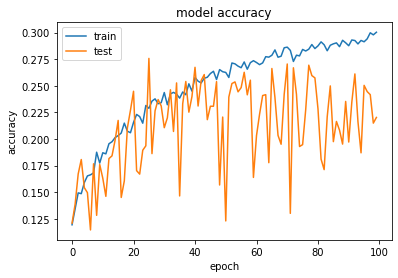

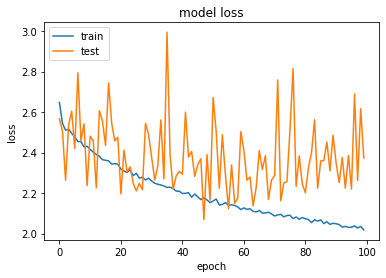

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
y_test_true_tmp = np.argmax(y_test, axis = 1)
label_count = np.unique(y_test_true_tmp, return_counts = True)[1]

In [0]:
# Define functions for evaluating model accuracy by class and overall

def eval_model_by_class(model, test_set):
  y_test_pred_tmp = model.predict_classes(test_set)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  pred_df = pred_df.groupby(['y_true']).sum().reset_index()
  pred_df['label_count'] = label_count
  pred_df['class_acc'] = pred_df.accurate_preds / pred_df.label_count
  pred_df = pred_df.sort_values(by = 'class_acc').reset_index()
  pred_df['overall_acc'] = sum(pred_df.accurate_preds) / sum(pred_df.label_count)
  pred_df = pred_df.sort_values('y_true').reset_index(drop = True)

  return(pred_df)

def find_wrong_preds(model, test_set):
  y_test_pred_tmp = model.predict_classes(test_set)

  y_test_true = [label_Dict[x] for x in y_test_true_tmp]
  y_test_pred = [label_Dict[x] for x in y_test_pred_tmp]

  pred_df = pd.DataFrame({'y_true': y_test_true, 'y_pred': y_test_pred})
  pred_df['accurate_preds'] = pred_df.y_true == pred_df.y_pred
  # pred_df = pred_df.sort_values('y_true').reset_index(drop = True)
  pred_df = pred_df.sort_values('y_true')

  return(pred_df)

In [0]:
M1_pred_df = eval_model_by_class(M1, X_test_BW)
M1_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',869.0,1500,0.579333,0.220296
1,1,b'Forest',6.0,1500,0.004000,0.220296
2,2,b'HerbaceousVegetation',2.0,1500,0.001333,0.220296
3,3,b'Highway',69.0,1250,0.055200,0.220296
4,4,b'Industrial',768.0,1250,0.614400,0.220296
5,5,b'Pasture',0.0,1000,0.000000,0.220296
6,6,b'PermanentCrop',0.0,1250,0.000000,0.220296
7,7,b'Residential',413.0,1500,0.275333,0.220296
8,8,b'River',0.0,1250,0.000000,0.220296
9,9,b'SeaLake',847.0,1500,0.564667,0.220296


### Second Model

- Implement a second deep learning model `M2` adding an additional dense layer to the previous model. 

- **Classification accuracy on the test data.** 33.6%

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M2.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M2 = Sequential()
M2.add(Dense(256, activation='relu', input_shape=(4096,)))
M2.add(Dense(num_classes, activation='softmax'))

M2.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_27 (Dense)             (None, 256)               1048832   
_________________________________________________________________
dense_28 (Dense)             (None, 10)                2570      
Total params: 1,051,402
Trainable params: 1,051,402
Non-trainable params: 0
_________________________________________________________________


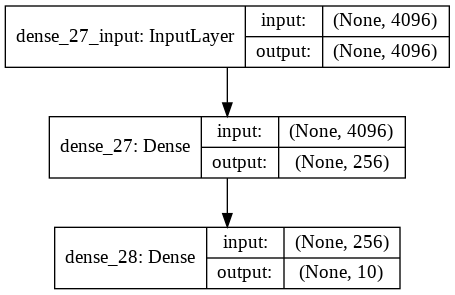

In [0]:
plot_model(M2, show_shapes=True, show_layer_names=True)

In [0]:
M2.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M2.fit(X_train_BW, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                 callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test_BW, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/100
13500/13500 [==============================] - 1s 95us/step - loss: 2.8588 - accuracy: 0.1158 - val_loss: 2.3722 - val_accuracy: 0.1214
Epoch 2/100
13500/13500 [==============================] - 1s 91us/step - loss: 2.2887 - accuracy: 0.1314 - val_loss: 2.2072 - val_accuracy: 0.1417
Epoch 3/100
13500/13500 [==============================] - 1s 90us/step - loss: 2.2078 - accuracy: 0.1587 - val_loss: 2.2594 - val_accuracy: 0.1488
Epoch 4/100
13500/13500 [==============================] - 1s 93us/step - loss: 2.1630 - accuracy: 0.1896 - val_loss: 2.1426 - val_accuracy: 0.1887
Epoch 5/100
13500/13500 [==============================] - 1s 91us/step - loss: 2.1291 - accuracy: 0.2142 - val_loss: 2.0978 - val_accuracy: 0.2393
Epoch 6/100
13500/13500 [==============================] - 1s 92us/step - loss: 2.1027 - accuracy: 0.2337 - val_loss: 2.1147 - val_accuracy: 0.2459
Epoch 7/100
13500/13500 [==============================] - 1s 

In [0]:
score = M2.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.7469050137201945
Test accuracy: 0.335999995470047


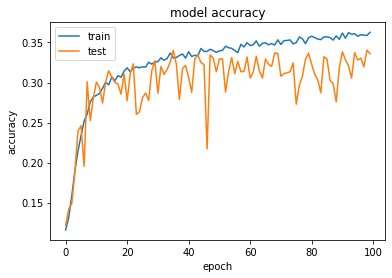

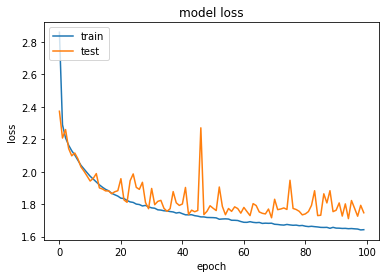

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M2_pred_df = eval_model_by_class(M2, X_test_BW)
M2_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',600.0,1500,0.400000,0.336
1,1,b'Forest',1045.0,1500,0.696667,0.336
2,2,b'HerbaceousVegetation',264.0,1500,0.176000,0.336
3,3,b'Highway',122.0,1250,0.097600,0.336
4,4,b'Industrial',807.0,1250,0.645600,0.336
5,5,b'Pasture',69.0,1000,0.069000,0.336
6,6,b'PermanentCrop',167.0,1250,0.133600,0.336
7,7,b'Residential',638.0,1500,0.425333,0.336
8,8,b'River',577.0,1250,0.461600,0.336
9,9,b'SeaLake',247.0,1500,0.164667,0.336


### Third Model

- Implement a third deep learning model `M3` adding two additional dense layers as well as drop-out layers to the previous model. 

- **Classification accuracy on the test data.** 25.8%
- **Compare against previous models. Which model was the "best"? Why?** Of the first three models, `M2` was the best. It had a higher accuracy on the test data, and based on the plots showing training/testing loss and accuracy, it fit the data better than either Models M1 or M3, which both showed large fluctuations in the testing loss and accuracy.

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M3.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M3 = Sequential()
M3.add(Dense(256, activation='relu', input_shape=(4096,)))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(256, activation='relu'))
M3.add(Dropout(0.2))
M3.add(Dense(num_classes, activation='softmax'))

M3.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               1048832   
_________________________________________________________________
dropout_14 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_30 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_15 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_31 (Dense)             (None, 256)               65792     
_________________________________________________________________
dropout_16 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_32 (Dense)             (None, 10)              

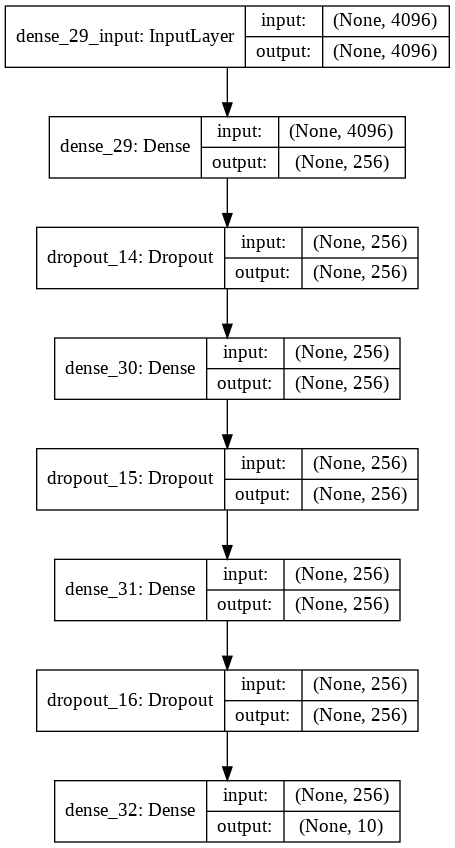

In [0]:
plot_model(M3, show_shapes=True, show_layer_names=True)

In [0]:
M3.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M3.fit(X_train_BW, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                 callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test_BW, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/100
13500/13500 [==============================] - 2s 112us/step - loss: 2.3189 - accuracy: 0.1305 - val_loss: 2.1538 - val_accuracy: 0.2186
Epoch 2/100
13500/13500 [==============================] - 1s 105us/step - loss: 2.1677 - accuracy: 0.1698 - val_loss: 2.0019 - val_accuracy: 0.2499
Epoch 3/100
13500/13500 [==============================] - 1s 107us/step - loss: 2.0863 - accuracy: 0.1968 - val_loss: 1.9344 - val_accuracy: 0.2230
Epoch 4/100
13500/13500 [==============================] - 1s 108us/step - loss: 2.0296 - accuracy: 0.2072 - val_loss: 1.9713 - val_accuracy: 0.2292
Epoch 5/100
13500/13500 [==============================] - 1s 109us/step - loss: 2.0048 - accuracy: 0.2229 - val_loss: 2.0225 - val_accuracy: 0.2217
Epoch 6/100
13500/13500 [==============================] - 1s 100us/step - loss: 1.9842 - accuracy: 0.2247 - val_loss: 1.9639 - val_accuracy: 0.2078
Epoch 7/100
13500/13500 [==============================]

In [0]:
score = M3.evaluate(X_test_BW, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.9760869298157868
Test accuracy: 0.25792592763900757


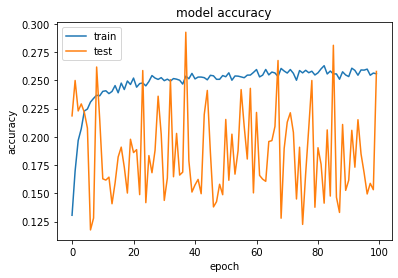

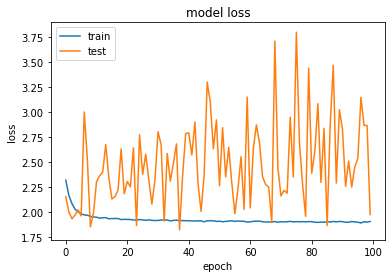

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M3_pred_df = eval_model_by_class(M3, X_test_BW)
M3_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',0.0,1500,0.000000,0.257926
1,1,b'Forest',1219.0,1500,0.812667,0.257926
2,2,b'HerbaceousVegetation',0.0,1500,0.000000,0.257926
3,3,b'Highway',0.0,1250,0.000000,0.257926
4,4,b'Industrial',665.0,1250,0.532000,0.257926
5,5,b'Pasture',124.0,1000,0.124000,0.257926
6,6,b'PermanentCrop',0.0,1250,0.000000,0.257926
7,7,b'Residential',643.0,1500,0.428667,0.257926
8,8,b'River',282.0,1250,0.225600,0.257926
9,9,b'SeaLake',549.0,1500,0.366000,0.257926


### Fourth Model

- Using RGB images (without vectorizing them), implement a fourth model `M4` that includes the following layers: Conv2D, MaxPooling2D, Dropout, Flatten, Dense. 

- **Classification accuracy on the test data.** 73.6%
- **Compare against previous models. Which model was the "best"? Why?** Model `M4` is clearly the best so far, with a testing accuracy of 73.6%. The inclusion of the convolutional and maxpooling layers added a spatial component to the model, boosting the predictive power significantly. Based on the divergence of the training/testing loss and accuracy plots, the model started overfitting the training data after 10 or so epochs.

In [0]:
input_shape = X_train.shape[1:]

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M4.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M4 = Sequential()
M4.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
M4.add(Conv2D(64, (3, 3), activation='relu'))
M4.add(MaxPooling2D(pool_size=(2, 2)))
M4.add(Dropout(0.2))
M4.add(Flatten())
M4.add(Dense(256, activation='relu'))
M4.add(Dropout(0.2))
M4.add(Dense(num_classes, activation='softmax'))

M4.summary()

Model: "sequential_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_15 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 60, 60, 64)        18496     
_________________________________________________________________
max_pooling2d_14 (MaxPooling (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_17 (Dropout)         (None, 30, 30, 64)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 57600)             0         
_________________________________________________________________
dense_33 (Dense)             (None, 256)               14745856  
_________________________________________________________________
dropout_18 (Dropout)         (None, 256)             

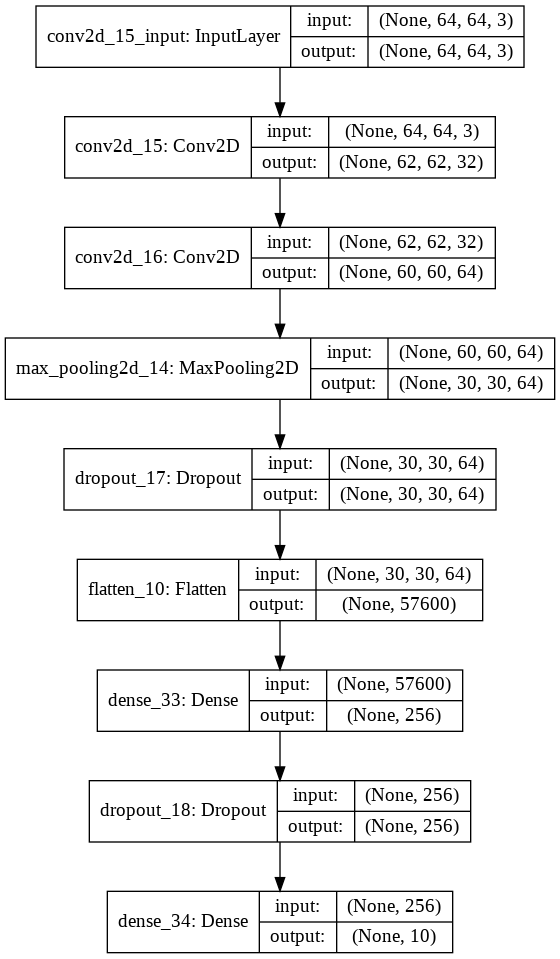

In [0]:
plot_model(M4, show_shapes=True, show_layer_names=True)

In [0]:
M4.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M4.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                 callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/100
13500/13500 [==============================] - 5s 398us/step - loss: 1.7562 - accuracy: 0.3856 - val_loss: 1.4685 - val_accuracy: 0.4731
Epoch 2/100
13500/13500 [==============================] - 5s 383us/step - loss: 1.1530 - accuracy: 0.5961 - val_loss: 1.4026 - val_accuracy: 0.4979
Epoch 3/100
13500/13500 [==============================] - 5s 379us/step - loss: 0.8882 - accuracy: 0.6818 - val_loss: 0.7281 - val_accuracy: 0.7441
Epoch 4/100
13500/13500 [==============================] - 5s 380us/step - loss: 0.7257 - accuracy: 0.7473 - val_loss: 0.7294 - val_accuracy: 0.7464
Epoch 5/100
13500/13500 [==============================] - 5s 380us/step - loss: 0.6222 - accuracy: 0.7909 - val_loss: 1.0390 - val_accuracy: 0.6501
Epoch 6/100
13500/13500 [==============================] - 5s 379us/step - loss: 0.5046 - accuracy: 0.8280 - val_loss: 1.1169 - val_accuracy: 0.6703
Epoch 7/100
13500/13500 [==============================]

In [0]:
score = M4.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 5.63783438707281
Test accuracy: 0.7364444732666016


Interestingly, testing loss deterioates rapidly rapidly after about 10 epochs, but testing accuracy deteriorates more slowly.

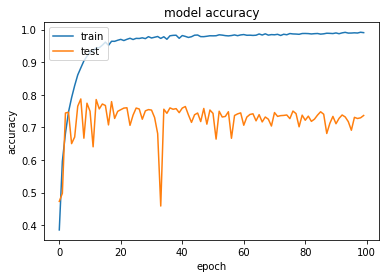

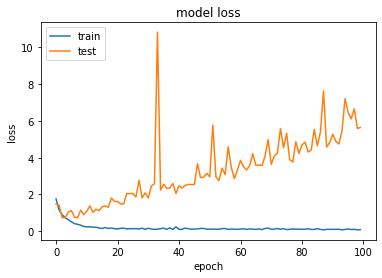

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M4_pred_df = eval_model_by_class(M4, X_test)
M4_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',1254.0,1500,0.836000,0.736444
1,1,b'Forest',1417.0,1500,0.944667,0.736444
2,2,b'HerbaceousVegetation',755.0,1500,0.503333,0.736444
3,3,b'Highway',747.0,1250,0.597600,0.736444
4,4,b'Industrial',1089.0,1250,0.871200,0.736444
5,5,b'Pasture',677.0,1000,0.677000,0.736444
6,6,b'PermanentCrop',541.0,1250,0.432800,0.736444
7,7,b'Residential',1332.0,1500,0.888000,0.736444
8,8,b'River',727.0,1250,0.581600,0.736444
9,9,b'SeaLake',1403.0,1500,0.935333,0.736444


### Models 5-9

- Using RGB images (without vectorizing them), implement a deep learning model targeting accuracy that will outperform all previous models. 

- **Describe the model you built, and why you chose it.** I built five more models
  - _M5:_ A model with 4 convolution-maxpooling layer pairs before a dropout layer and a dense layer. I added the additional convolutions to try to extract larger features in each image.
  - _M6:_ This model is M5, but I replaced the convolutional layers with the convolutional base of the `VGG16` model instead.[3] I ran this once with the pre-loaded weights, and I ran it again with some of the convolutional layers in VGG16 unfrozen and a lower learning rate to extract some of the lower level features from the EuroSAT images. Unfreezing the weights improved the model by about 1.6 percentage points. I created this model to see (1) the effect transfer learning would have on my accuracy and (2) the improvements I could get from fine-tuning the pre-loaded weights.
  - _M7:_ This model is the same as M6 but uses training data that has been augmented through random shearing, rotating, and flipping. I wanted to see if this would improve the overfitting I'd been seeing in some of my models.
  - _M8:_ This was my best model. It has the same layers and data augmentation as M7, but it also includes two callbacks: `EarlyStopping` to reduce overfitting and keep the weights from the epoch with the lowest validation loss and `ReduceLROnPlateau` to decay the learning rate as validation loss improvements slow.
  - _M9:_ This model is the same as M5 but uses the data augmentation and callbacks described in M8.

- **Classification accuracy on the test data.**
  - _M5:_ 86.1%
  - _M6:_ 86.3% with pre-loaded VGG16 weights and 87.2% with additional fine-tuning
  - _M7:_ 90.2%
  - _M8:_ 94.5%
  - _M9:_ 91.2%

- **Compare against previous models. Which model was the "best"? Why?** M8, which uses VGG16's convolutional base, augmented data, and callbacks, had the best performance. In terms of accuracy, it correctly classified 94.5% of the test set. Based on the training/testing accuracy and loss plots, the two models with callbacks clearly performed better from an overfitting perspective. The decay in the learning rate also helped the model make marginal improvements in validation loss more quickly than previous models. Lastly, EarlyStopping reduced the training time and allowed me to retain the weights from the epoch with the lowest validation loss.

- **What are the two classes with the highest labeling error? Explain using data and showing mis-classified examples.** The highest errors were in the SeaLake and AnnualCrop images, which both had accuracies in the low 90's, well below the other categories. As shown in the examples, they were most often confused with Forest and PermanentCrop/Pasture, respectively.

> **[3]** Very Deep Convolutional Networks for Large-Scale Image Recognition
K. Simonyan, A. Zisserman
arXiv:1409.1556

**M5** 

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M5.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M5 = Sequential()
M5.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
M5.add(MaxPooling2D(pool_size=(2, 2)))
M5.add(Conv2D(64, (3, 3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2)))
M5.add(Conv2D(128, (3, 3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2)))
M5.add(Conv2D(256, (3, 3), activation='relu'))
M5.add(MaxPooling2D(pool_size=(2, 2)))
M5.add(Flatten())
M5.add(Dropout(0.5))
M5.add(Dense(512, activation='relu'))
# M5.add(Dropout(0.2))
M5.add(Dense(num_classes, activation='softmax'))

M5.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_17 (Conv2D)           (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 29, 29, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 12, 12, 128)       73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 6, 6, 128)         0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 4, 4, 256)       

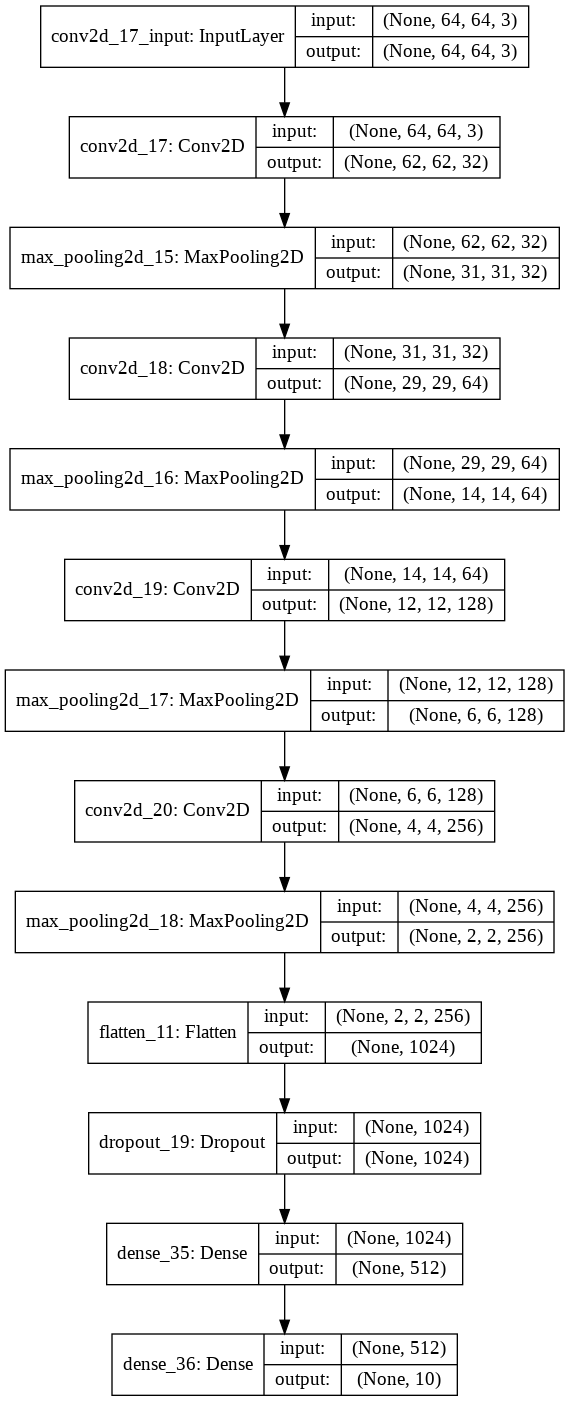

In [0]:
plot_model(M5, show_shapes=True, show_layer_names=True)

In [0]:
M5.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M5.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                 callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/100
13500/13500 [==============================] - 4s 277us/step - loss: 1.8215 - accuracy: 0.3053 - val_loss: 1.8194 - val_accuracy: 0.3157
Epoch 2/100
13500/13500 [==============================] - 3s 255us/step - loss: 1.2870 - accuracy: 0.5261 - val_loss: 1.0515 - val_accuracy: 0.6401
Epoch 3/100
13500/13500 [==============================] - 3s 253us/step - loss: 1.0559 - accuracy: 0.6182 - val_loss: 0.8101 - val_accuracy: 0.7170
Epoch 4/100
13500/13500 [==============================] - 3s 249us/step - loss: 0.9118 - accuracy: 0.6719 - val_loss: 0.7043 - val_accuracy: 0.7510
Epoch 5/100
13500/13500 [==============================] - 3s 249us/step - loss: 0.8130 - accuracy: 0.7101 - val_loss: 0.6708 - val_accuracy: 0.7683
Epoch 6/100
13500/13500 [==============================] - 3s 250us/step - loss: 0.7434 - accuracy: 0.7383 - val_loss: 0.8048 - val_accuracy: 0.7239
Epoch 7/100
13500/13500 [==============================]

In [0]:
score = M5.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.7529503893907423
Test accuracy: 0.8611111044883728


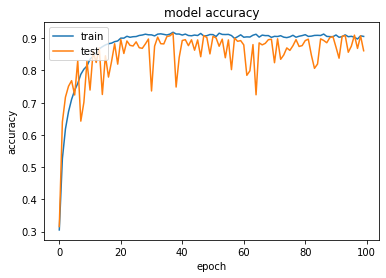

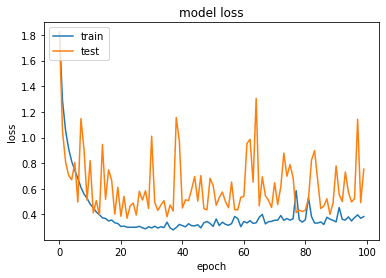

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M5_pred_df = eval_model_by_class(M5, X_test)
M5_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',1381.0,1500,0.920667,0.861111
1,1,b'Forest',1257.0,1500,0.838000,0.861111
2,2,b'HerbaceousVegetation',797.0,1500,0.531333,0.861111
3,3,b'Highway',1076.0,1250,0.860800,0.861111
4,4,b'Industrial',1236.0,1250,0.988800,0.861111
5,5,b'Pasture',987.0,1000,0.987000,0.861111
6,6,b'PermanentCrop',981.0,1250,0.784800,0.861111
7,7,b'Residential',1420.0,1500,0.946667,0.861111
8,8,b'River',1077.0,1250,0.861600,0.861111
9,9,b'SeaLake',1413.0,1500,0.942000,0.861111


**M6:** Use `VGG16` convolutional base for Transfer Learning

In [0]:
conv_base = vgg16.VGG16(include_top=False,
            input_shape = input_shape)

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

In [0]:
# how many weights are trainable in the VGG16 model?
len(conv_base.trainable_weights)

26

In [0]:
# freeze the weights
for layer in conv_base.layers:
  layer.trainable = False

In [0]:
# now there are 0
len(conv_base.trainable_weights)

0

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M6.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M6 = Sequential()

M6.add(conv_base)

M6.add(Flatten())
M6.add(Dropout(0.5))
M6.add(Dense(512, activation='relu'))
M6.add(Dense(num_classes, activation='softmax'))

M6.summary()

Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 2, 2, 512)         14714688  
_________________________________________________________________
flatten_12 (Flatten)         (None, 2048)              0         
_________________________________________________________________
dropout_20 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_37 (Dense)             (None, 512)               1049088   
_________________________________________________________________
dense_38 (Dense)             (None, 10)                5130      
Total params: 15,768,906
Trainable params: 1,054,218
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 32, 32, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 32, 32, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 32, 32, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 16, 16, 128)       0     

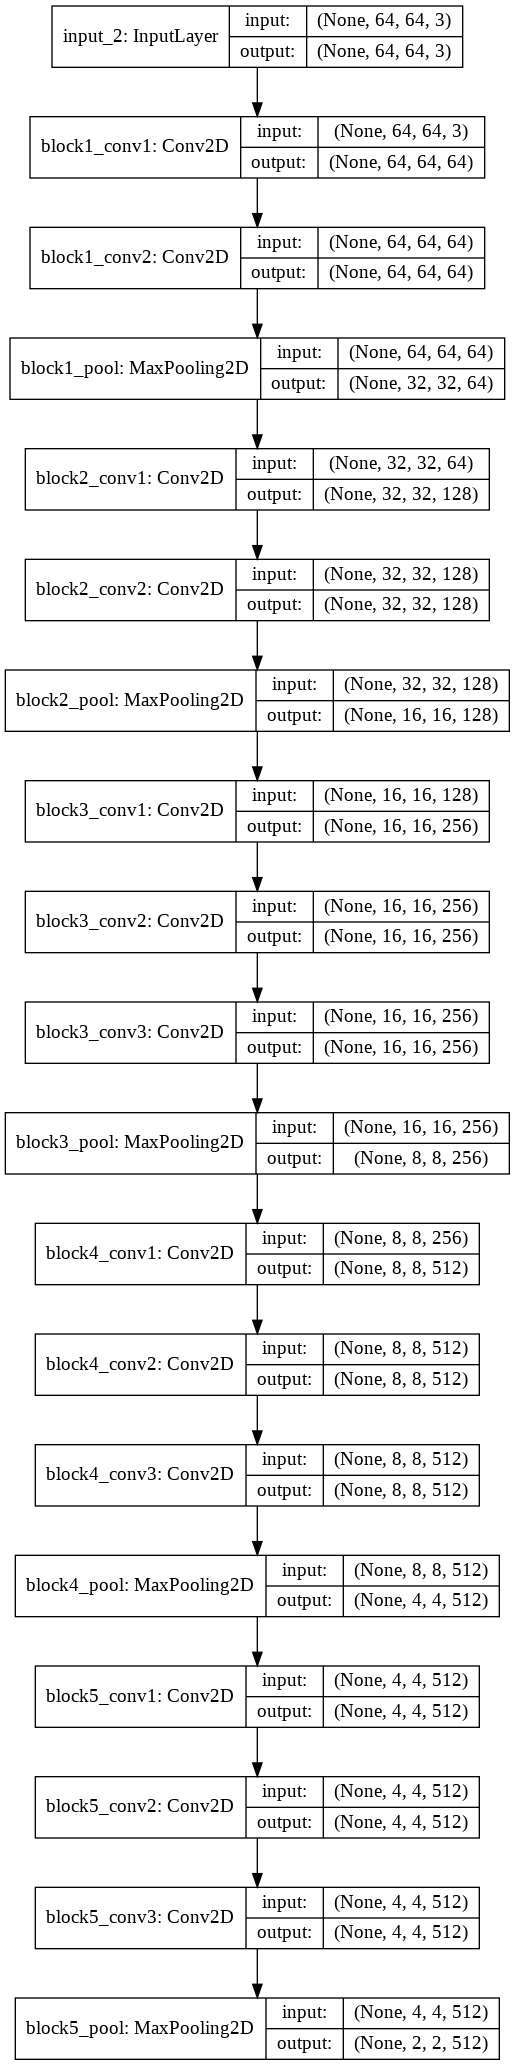

In [0]:
plot_model(conv_base, show_shapes=True, show_layer_names=True)

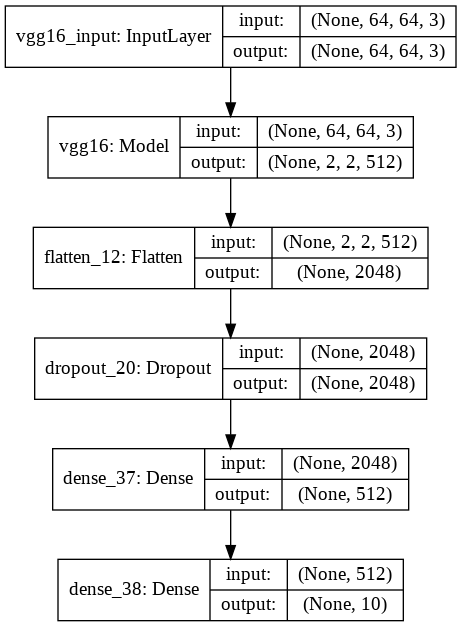

In [0]:
plot_model(M6, show_shapes=True, show_layer_names=True)

In [0]:
M6.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(),
              metrics=['accuracy'])

In [0]:
history = M6.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                 callbacks = callback_list,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/100
13500/13500 [==============================] - 8s 595us/step - loss: 0.9680 - accuracy: 0.6539 - val_loss: 0.6887 - val_accuracy: 0.7506
Epoch 2/100
13500/13500 [==============================] - 8s 581us/step - loss: 0.7071 - accuracy: 0.7485 - val_loss: 0.5767 - val_accuracy: 0.7943
Epoch 3/100
13500/13500 [==============================] - 8s 585us/step - loss: 0.6456 - accuracy: 0.7703 - val_loss: 0.5384 - val_accuracy: 0.8105
Epoch 4/100
13500/13500 [==============================] - 8s 585us/step - loss: 0.5982 - accuracy: 0.7924 - val_loss: 0.5402 - val_accuracy: 0.8050
Epoch 5/100
13500/13500 [==============================] - 8s 585us/step - loss: 0.5746 - accuracy: 0.7979 - val_loss: 0.5009 - val_accuracy: 0.8270
Epoch 6/100
13500/13500 [==============================] - 8s 586us/step - loss: 0.5462 - accuracy: 0.8086 - val_loss: 0.4617 - val_accuracy: 0.8417
Epoch 7/100
13500/13500 [==============================]

In [0]:
score = M6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.6390535266885051
Test accuracy: 0.8625184893608093


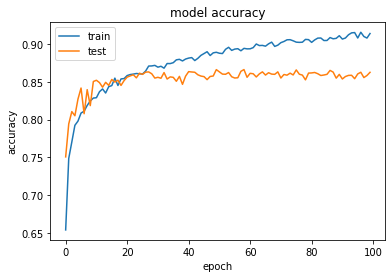

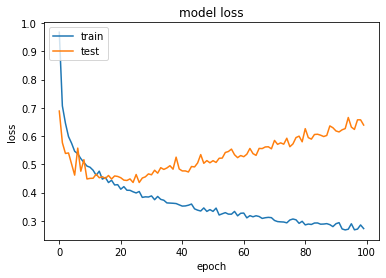

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**M6 (Part II):** Unfreeze some layers in the convolutional base

In [0]:
# unfreeze the latter 2/3ds of the base
for layer in conv_base.layers[7:]:
  layer.trainable = True

In [0]:
len(conv_base.trainable_weights)

18

In [0]:
# set a lower learning rate to minimize magnitude of changes to weights
M6.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr = 1e-4),
              metrics=['accuracy'])

In [0]:
history = M6.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,
                    validation_data=(X_test, y_test))

Train on 13500 samples, validate on 13500 samples
Epoch 1/100
13500/13500 [==============================] - 12s 906us/step - loss: 2.9764 - accuracy: 0.4079 - val_loss: 1.2144 - val_accuracy: 0.5627
Epoch 2/100
13500/13500 [==============================] - 12s 885us/step - loss: 0.8227 - accuracy: 0.7390 - val_loss: 0.5929 - val_accuracy: 0.8085
Epoch 3/100
13500/13500 [==============================] - 12s 874us/step - loss: 0.5399 - accuracy: 0.8423 - val_loss: 0.3810 - val_accuracy: 0.8819
Epoch 4/100
13500/13500 [==============================] - 12s 874us/step - loss: 0.4277 - accuracy: 0.8813 - val_loss: 0.2811 - val_accuracy: 0.9165
Epoch 5/100
13500/13500 [==============================] - 12s 876us/step - loss: 0.3431 - accuracy: 0.9054 - val_loss: 0.2706 - val_accuracy: 0.9206
Epoch 6/100
13500/13500 [==============================] - 12s 874us/step - loss: 0.3171 - accuracy: 0.9128 - val_loss: 0.2733 - val_accuracy: 0.9290
Epoch 7/100
13500/13500 [=========================

In [0]:
score = M6.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 1.672975609814679
Test accuracy: 0.871925950050354


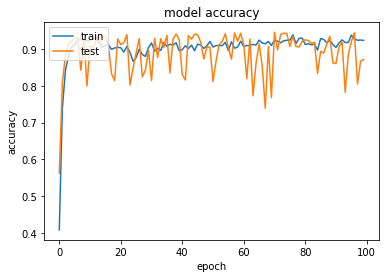

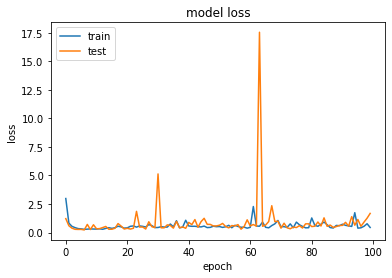

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M6_pred_df = eval_model_by_class(M6, X_test)

**M7:** Data Augmentation

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M7.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [checkpoint]

In [0]:
M7 = Sequential()

M7.add(conv_base)

M7.add(Flatten())
M7.add(Dropout(0.5))
M7.add(Dense(512, activation='relu'))
M7.add(Dense(num_classes, activation='softmax'))

M7.compile(loss='categorical_crossentropy',
              optimizer=RMSprop(lr = 1e-4),
              metrics=['accuracy'])

In [0]:
train_datagen = ImageDataGenerator(
    # rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    rotation_range=180,
    horizontal_flip=True,
    vertical_flip=True)

test_datagen = ImageDataGenerator()

In [0]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = batch_size,
    seed = 42
)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size = batch_size,
    seed = 42
)

In [0]:
history = M7.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size,
                 epochs = epochs,
                 callbacks = callback_list,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size)

Epoch 1/100
210/210 [==============================] - 17s 81ms/step - loss: 1.4235 - accuracy: 0.6147 - val_loss: 0.4833 - val_accuracy: 0.8497
Epoch 2/100
210/210 [==============================] - 17s 82ms/step - loss: 0.6549 - accuracy: 0.8365 - val_loss: 0.7789 - val_accuracy: 0.8861
Epoch 3/100
210/210 [==============================] - 17s 82ms/step - loss: 0.5686 - accuracy: 0.8568 - val_loss: 0.0660 - val_accuracy: 0.9300
Epoch 4/100
210/210 [==============================] - 17s 82ms/step - loss: 0.5223 - accuracy: 0.8703 - val_loss: 0.2072 - val_accuracy: 0.9093
Epoch 5/100
210/210 [==============================] - 17s 80ms/step - loss: 0.4705 - accuracy: 0.8855 - val_loss: 0.1184 - val_accuracy: 0.9349
Epoch 6/100
210/210 [==============================] - 17s 80ms/step - loss: 0.4722 - accuracy: 0.8872 - val_loss: 0.7060 - val_accuracy: 0.8928
Epoch 7/100
210/210 [==============================] - 17s 80ms/step - loss: 0.4592 - accuracy: 0.8840 - val_loss: 0.2377 - val_ac

In [0]:
score = M7.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.422445466571384
Test accuracy: 0.9017778038978577


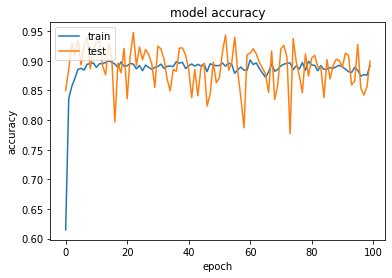

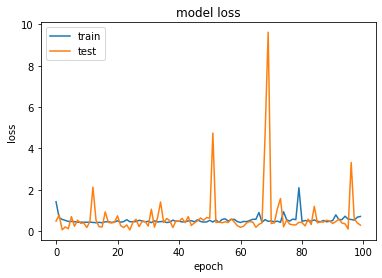

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M7_pred_df = eval_model_by_class(M7, X_test)
M7_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',938.0,1500,0.625333,0.901778
1,1,b'Forest',1477.0,1500,0.984667,0.901778
2,2,b'HerbaceousVegetation',1453.0,1500,0.968667,0.901778
3,3,b'Highway',1195.0,1250,0.956000,0.901778
4,4,b'Industrial',1212.0,1250,0.969600,0.901778
5,5,b'Pasture',893.0,1000,0.893000,0.901778
6,6,b'PermanentCrop',966.0,1250,0.772800,0.901778
7,7,b'Residential',1491.0,1500,0.994000,0.901778
8,8,b'River',1162.0,1250,0.929600,0.901778
9,9,b'SeaLake',1387.0,1500,0.924667,0.901778


**M8:** Try M7 again but add `EarlyStopping` and `ReduceLROnPlateau`

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M8.h5'

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [0]:
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = RMSprop(lr = 1e-4)
lr_metric = get_lr_metric(optimizer)

In [0]:
M8 = Sequential()

M8.add(conv_base)

M8.add(Flatten())
M8.add(Dropout(0.5))
M8.add(Dense(512, activation='relu'))
M8.add(Dense(num_classes, activation='softmax'))

M8.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
history = M8.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size,
                 epochs = epochs,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size,
                 callbacks = callback_list)

Epoch 1/100
210/210 [==============================] - 17s 83ms/step - loss: 1.5642 - accuracy: 0.5444 - lr: 1.0000e-04 - val_loss: 1.5415 - val_accuracy: 0.8157 - val_lr: 1.0000e-04
Epoch 2/100
210/210 [==============================] - 18s 83ms/step - loss: 0.8959 - accuracy: 0.7694 - lr: 1.0000e-04 - val_loss: 0.5431 - val_accuracy: 0.9055 - val_lr: 1.0000e-04
Epoch 3/100
210/210 [==============================] - 17s 83ms/step - loss: 0.6812 - accuracy: 0.8179 - lr: 1.0000e-04 - val_loss: 0.2872 - val_accuracy: 0.9141 - val_lr: 1.0000e-04
Epoch 4/100
210/210 [==============================] - 17s 83ms/step - loss: 0.5938 - accuracy: 0.8579 - lr: 1.0000e-04 - val_loss: 0.4622 - val_accuracy: 0.9253 - val_lr: 1.0000e-04
Epoch 5/100
210/210 [==============================] - 17s 82ms/step - loss: 0.5322 - accuracy: 0.8677 - lr: 1.0000e-04 - val_loss: 0.9251 - val_accuracy: 0.8392 - val_lr: 1.0000e-04
Epoch 6/100
210/210 [==============================] - 17s 82ms/step - loss: 0.4738 -

In [0]:
score = M8.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.39065312901967103
Test accuracy: 0.9448888897895813


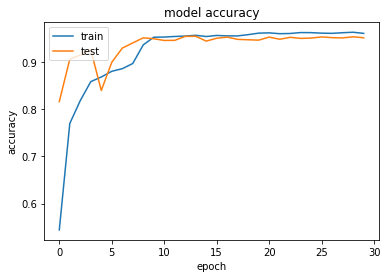

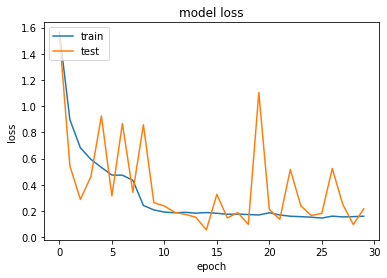

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M8_pred_df = eval_model_by_class(M8, X_test)
M8_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',1370.0,1500,0.913333,0.944889
1,1,b'Forest',1497.0,1500,0.998000,0.944889
2,2,b'HerbaceousVegetation',1396.0,1500,0.930667,0.944889
3,3,b'Highway',1186.0,1250,0.948800,0.944889
4,4,b'Industrial',1195.0,1250,0.956000,0.944889
5,5,b'Pasture',914.0,1000,0.914000,0.944889
6,6,b'PermanentCrop',1166.0,1250,0.932800,0.944889
7,7,b'Residential',1498.0,1500,0.998667,0.944889
8,8,b'River',1172.0,1250,0.937600,0.944889
9,9,b'SeaLake',1362.0,1500,0.908000,0.944889


**M9:** Try M5 but with data augmentation and callbacks

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M9.h5'

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

optimizer = RMSprop()
lr_metric = get_lr_metric(optimizer)

In [0]:
M9 = Sequential()
# same as M5
M9.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
M9.add(MaxPooling2D(pool_size=(2, 2)))
M9.add(Conv2D(64, (3, 3), activation='relu'))
M9.add(MaxPooling2D(pool_size=(2, 2)))
M9.add(Conv2D(128, (3, 3), activation='relu'))
M9.add(MaxPooling2D(pool_size=(2, 2)))
M9.add(Conv2D(256, (3, 3), activation='relu'))
M9.add(MaxPooling2D(pool_size=(2, 2)))


M9.add(Flatten())
M9.add(Dropout(0.5))
M9.add(Dense(512, activation='relu'))
M9.add(Dense(num_classes, activation='softmax'))

M9.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
history = M9.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size,
                 epochs = epochs,
                 callbacks = callback_list,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size)

Epoch 1/100
210/210 [==============================] - 14s 65ms/step - loss: 1.8206 - accuracy: 0.3054 - lr: 0.0010 - val_loss: 1.5900 - val_accuracy: 0.3717 - val_lr: 0.0010
Epoch 2/100
210/210 [==============================] - 14s 66ms/step - loss: 1.3740 - accuracy: 0.4814 - lr: 0.0010 - val_loss: 1.1084 - val_accuracy: 0.5933 - val_lr: 0.0010
Epoch 3/100
210/210 [==============================] - 14s 65ms/step - loss: 1.1705 - accuracy: 0.5758 - lr: 0.0010 - val_loss: 1.1901 - val_accuracy: 0.5107 - val_lr: 0.0010
Epoch 4/100
210/210 [==============================] - 14s 66ms/step - loss: 1.0327 - accuracy: 0.6306 - lr: 0.0010 - val_loss: 0.8312 - val_accuracy: 0.6919 - val_lr: 0.0010
Epoch 5/100
210/210 [==============================] - 14s 67ms/step - loss: 0.9209 - accuracy: 0.6666 - lr: 0.0010 - val_loss: 0.5759 - val_accuracy: 0.7248 - val_lr: 0.0010
Epoch 6/100
210/210 [==============================] - 14s 66ms/step - loss: 0.8327 - accuracy: 0.6992 - lr: 0.0010 - val_los

In [0]:
score = M9.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.27316765398890885
Test accuracy: 0.9124444723129272


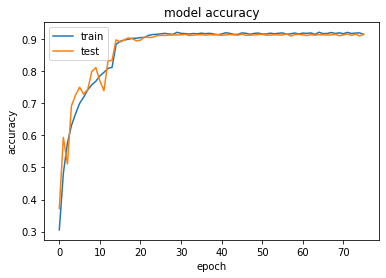

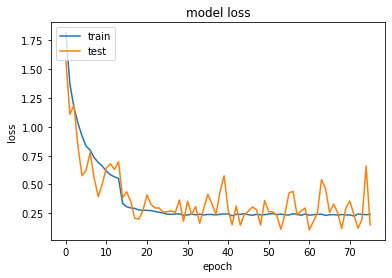

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M9_pred_df = eval_model_by_class(M9, X_test)
M9_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',1306.0,1500,0.870667,0.912444
1,1,b'Forest',1468.0,1500,0.978667,0.912444
2,2,b'HerbaceousVegetation',1243.0,1500,0.828667,0.912444
3,3,b'Highway',1085.0,1250,0.868000,0.912444
4,4,b'Industrial',1198.0,1250,0.958400,0.912444
5,5,b'Pasture',917.0,1000,0.917000,0.912444
6,6,b'PermanentCrop',1047.0,1250,0.837600,0.912444
7,7,b'Residential',1479.0,1500,0.986000,0.912444
8,8,b'River',1129.0,1250,0.903200,0.912444
9,9,b'SeaLake',1446.0,1500,0.964000,0.912444


Dataframe with all results

In [0]:
all_pred_df = M1_pred_df.loc[:, ['y_true', 'label_count']]
all_pred_df['M1_class_acc'] = M1_pred_df.loc[:, 'class_acc']
all_pred_df['M1_overall_acc'] = M1_pred_df.loc[:, 'overall_acc']

all_pred_df['M2_class_acc'] = M2_pred_df.loc[:, 'class_acc']
all_pred_df['M2_overall_acc'] = M2_pred_df.loc[:, 'overall_acc']

all_pred_df['M3_class_acc'] = M3_pred_df.loc[:, 'class_acc']
all_pred_df['M3_overall_acc'] = M3_pred_df.loc[:, 'overall_acc']

all_pred_df['M4_class_acc'] = M4_pred_df.loc[:, 'class_acc']
all_pred_df['M4_overall_acc'] = M4_pred_df.loc[:, 'overall_acc']

all_pred_df['M5_class_acc'] = M5_pred_df.loc[:, 'class_acc']
all_pred_df['M5_overall_acc'] = M5_pred_df.loc[:, 'overall_acc']

all_pred_df['M6_class_acc'] = M6_pred_df.loc[:, 'class_acc']
all_pred_df['M6_overall_acc'] = M6_pred_df.loc[:, 'overall_acc']

all_pred_df['M7_class_acc'] = M7_pred_df.loc[:, 'class_acc']
all_pred_df['M7_overall_acc'] = M7_pred_df.loc[:, 'overall_acc']

all_pred_df['M8_class_acc'] = M8_pred_df.loc[:, 'class_acc']
all_pred_df['M8_overall_acc'] = M8_pred_df.loc[:, 'overall_acc']

all_pred_df['M9_class_acc'] = M9_pred_df.loc[:, 'class_acc']
all_pred_df['M9_overall_acc'] = M9_pred_df.loc[:, 'overall_acc']

all_pred_df

,y_true,label_count,M1_class_acc,M1_overall_acc,M2_class_acc,M2_overall_acc,M3_class_acc,M3_overall_acc,M4_class_acc,M4_overall_acc,M5_class_acc,M5_overall_acc,M6_class_acc,M6_overall_acc,M7_class_acc,M7_overall_acc,M8_class_acc,M8_overall_acc,M9_class_acc,M9_overall_acc
0,b'AnnualCrop',1500,0.579333,0.220296,0.400000,0.336,0.000000,0.257926,0.836000,0.736444,0.920667,0.861111,0.914000,0.862519,0.625333,0.901778,0.913333,0.944889,0.870667,0.912444
1,b'Forest',1500,0.004000,0.220296,0.696667,0.336,0.812667,0.257926,0.944667,0.736444,0.838000,0.861111,0.966667,0.862519,0.984667,0.901778,0.998000,0.944889,0.978667,0.912444
2,b'HerbaceousVegetation',1500,0.001333,0.220296,0.176000,0.336,0.000000,0.257926,0.503333,0.736444,0.531333,0.861111,0.847333,0.862519,0.968667,0.901778,0.930667,0.944889,0.828667,0.912444
3,b'Highway',1250,0.055200,0.220296,0.097600,0.336,0.000000,0.257926,0.597600,0.736444,0.860800,0.861111,0.700800,0.862519,0.956000,0.901778,0.948800,0.944889,0.868000,0.912444
4,b'Industrial',1250,0.614400,0.220296,0.645600,0.336,0.532000,0.257926,0.871200,0.736444,0.988800,0.861111,0.906400,0.862519,0.969600,0.901778,0.956000,0.944889,0.958400,0.912444
5,b'Pasture',1000,0.000000,0.220296,0.069000,0.336,0.124000,0.257926,0.677000,0.736444,0.987000,0.861111,0.805000,0.862519,0.893000,0.901778,0.914000,0.944889,0.917000,0.912444
6,b'PermanentCrop',1250,0.000000,0.220296,0.133600,0.336,0.000000,0.257926,0.432800,0.736444,0.784800,0.861111,0.760800,0.862519,0.772800,0.901778,0.932800,0.944889,0.837600,0.912444
7,b'Residential',1500,0.275333,0.220296,0.425333,0.336,0.428667,0.257926,0.888000,0.736444,0.946667,0.861111,0.953333,0.862519,0.994000,0.901778,0.998667,0.944889,0.986000,0.912444
8,b'River',1250,0.000000,0.220296,0.461600,0.336,0.225600,0.257926,0.581600,0.736444,0.861600,0.861111,0.761600,0.862519,0.929600,0.901778,0.937600,0.944889,0.903200,0.912444
9,b'SeaLake',1500,0.564667,0.220296,0.164667,0.336,0.366000,0.257926,0.935333,0.736444,0.942000,0.861111,0.936667,0.862519,0.924667,0.901778,0.908000,0.944889,0.964000,0.912444


Examples of SeaLake and AnnualCrop Misclassifications

In [0]:
wrong_preds = find_wrong_preds(M8, X_test)
M8_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',1370.0,1500,0.913333,0.944889
1,1,b'Forest',1497.0,1500,0.998000,0.944889
2,2,b'HerbaceousVegetation',1396.0,1500,0.930667,0.944889
3,3,b'Highway',1186.0,1250,0.948800,0.944889
4,4,b'Industrial',1195.0,1250,0.956000,0.944889
5,5,b'Pasture',914.0,1000,0.914000,0.944889
6,6,b'PermanentCrop',1166.0,1250,0.932800,0.944889
7,7,b'Residential',1498.0,1500,0.998667,0.944889
8,8,b'River',1172.0,1250,0.937600,0.944889
9,9,b'SeaLake',1362.0,1500,0.908000,0.944889


In [0]:
label_names

array([b'AnnualCrop', b'Forest', b'HerbaceousVegetation', b'Highway',
       b'Industrial', b'Pasture', b'PermanentCrop', b'Residential',
       b'River', b'SeaLake'], dtype='|S20')

In [0]:
wrong_preds

,y_true,y_pred,accurate_preds
0,b'AnnualCrop',b'PermanentCrop',False
11220,b'AnnualCrop',b'AnnualCrop',True
3686,b'AnnualCrop',b'AnnualCrop',True
3690,b'AnnualCrop',b'AnnualCrop',True
3695,b'AnnualCrop',b'AnnualCrop',True
...,...,...,...
11737,b'SeaLake',b'SeaLake',True
6885,b'SeaLake',b'SeaLake',True
2786,b'SeaLake',b'SeaLake',True
6828,b'SeaLake',b'SeaLake',True


In [0]:
wrong_preds_SeaLake = wrong_preds[(wrong_preds.accurate_preds == False) &
                                  (wrong_preds.y_true == label_names[9])]

wrong_preds_AnnualCrop = wrong_preds[(wrong_preds.accurate_preds == False) &
                                     (wrong_preds.y_true == label_names[0])]

SeaLake examples

In [0]:
# Most misclassifications for SeaLake was Forest
wrong_preds_SeaLake.groupby(['y_pred']).size()

y_pred
b'AnnualCrop'              18
b'Forest'                  73
b'HerbaceousVegetation'    13
b'Pasture'                 19
b'PermanentCrop'            1
b'River'                   14
dtype: int64

In [0]:
wrong_preds_SeaLake.index

Int64Index([12484, 13424,  1581,  8999,  8329,  1566,  8279, 12564,  8507,
            13381,
            ...
            11435,  3247,  3159,  6673,  9405,  2634,  2673,  2681,  9278,
             9331],
           dtype='int64', length=138)

This is a b'SeaLake'
It was mislabeled as a b'Forest'


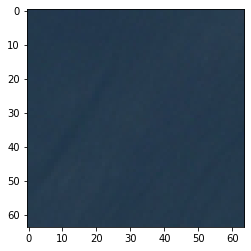

In [0]:
# Example 1
i = wrong_preds_SeaLake.index[0]

print("This is a " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as a " + str(wrong_preds_SeaLake.y_pred[i]))
plt.imshow(X_test[i]);

This is a b'SeaLake'
It was mislabeled as a b'AnnualCrop'


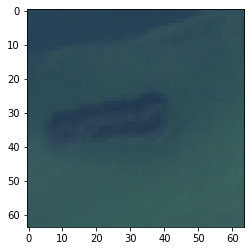

In [0]:
# Example 2
i = wrong_preds_SeaLake.index[100]

print("This is a " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as a " + str(wrong_preds_SeaLake.y_pred[i]))
plt.imshow(X_test[i]);

This is a b'SeaLake'
It was mislabeled as a b'Forest'


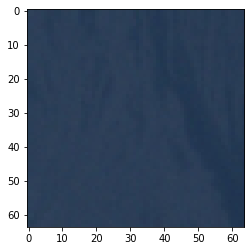

In [0]:
# Example 3
i = wrong_preds_SeaLake.index[40]

print("This is a " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as a " + str(wrong_preds_SeaLake.y_pred[i]))
plt.imshow(X_test[i]);

AnnualCrop Examples

In [0]:
# Most misclassifications for HerbaceousVegetation were PermanentCrop or Pasture
wrong_preds_AnnualCrop.groupby(['y_pred']).size()

y_pred
b'Forest'                  13
b'HerbaceousVegetation'     2
b'Highway'                  3
b'Industrial'               3
b'Pasture'                 32
b'PermanentCrop'           69
b'River'                    4
b'SeaLake'                  4
dtype: int64

This is a b'AnnualCrop'
It was mislabeled as a b'PermanentCrop'


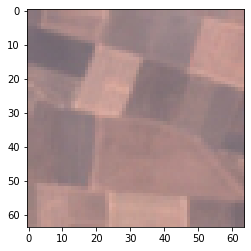

In [0]:
# Example 1
i = wrong_preds_AnnualCrop.index[0]

print("This is a " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as a " + str(wrong_preds_AnnualCrop.y_pred[i]))
plt.imshow(X_test[i]);

This is a b'AnnualCrop'
It was mislabeled as a b'PermanentCrop'


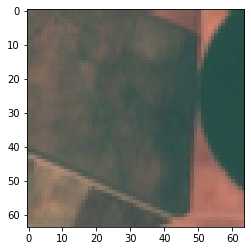

In [0]:
# Example 2
i = wrong_preds_AnnualCrop.index[75]

print("This is a " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as a " + str(wrong_preds_AnnualCrop.y_pred[i]))
plt.imshow(X_test[i]);

This is a b'AnnualCrop'
It was mislabeled as a b'PermanentCrop'


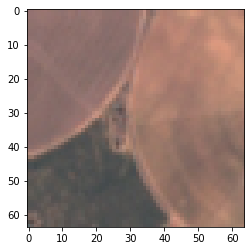

In [0]:
# Example 3
i = wrong_preds_AnnualCrop.index[120]

print("This is a " + str(label_Dict[y_test_true_tmp[i]]))
print("It was mislabeled as a " + str(wrong_preds_AnnualCrop.y_pred[i]))
plt.imshow(X_test[i]);

### Multispectral Images

- **Apply your best model on multispectral images.** I re-trained three models using the multispectral images:
  - _M\_MS:_ My second-best RGB model, which did not use VGG16. 
  - _M2\_MS:_ My best RGB model, which used VGG16 as a convolutional base. I modified the first convolutional layer to accept 13 channels.
  - _M3\_MS:_ My best RGB model again. This time, I unfroze all the layers in the VGG16 component to see if re-training the entire architecture with EuroSAT images would help.
- **Classification accuracy on the test data.** 
  - _M\_MS:_ 94.9% compared to 91.2% for the RGB version
  - _M2\_MS:_ 92.3% compared to 94.5% for the RGB version
  - _M3\_MS:_ 91.9%

Read multi-spectral images as 64x64x13 numpy arrays

In [0]:
# RGB file URL
url = "http://madm.dfki.de/files/sentinel/EuroSATallBands.zip"

# download zip
r = requests.get(url)
z = zipfile.ZipFile(io.BytesIO(r.content))

In [0]:
# get file names
txtfiles = []
for file in z.namelist():
  txtfiles.append(file)

# keep only those containing ".tif"
txtfiles = [x for x in txtfiles if ".tif" in x]

In [0]:
def normalizeBand(band):
  band_norm = np.interp(band, (band.min(), band.max()), (0, 1))
  return band_norm

In [0]:
XImages_MS = np.zeros([len(txtfiles), 64, 64, 13], dtype="float32")

i = 0
for pic in txtfiles:
  print(i)
  with rasterio.open(z.open(pic)) as img:
    tmp = np.moveaxis(img.read(), 0, 2)
    XImages_MS[i] = normalizeBand(tmp)
    i += 1

del r # clear memory
del z 

Streaming output truncated to the last 5000 lines.
22001
22002
22003
22004
22005
22006
22007
22008
22009
22010
22011
22012
22013
22014
22015
22016
22017
22018
22019
22020
22021
22022
22023
22024
22025
22026
22027
22028
22029
22030
22031
22032
22033
22034
22035
22036
22037
22038
22039
22040
22041
22042
22043
22044
22045
22046
22047
22048
22049
22050
22051
22052
22053
22054
22055
22056
22057
22058
22059
22060
22061
22062
22063
22064
22065
22066
22067
22068
22069
22070
22071
22072
22073
22074
22075
22076
22077
22078
22079
22080
22081
22082
22083
22084
22085
22086
22087
22088
22089
22090
22091
22092
22093
22094
22095
22096
22097
22098
22099
22100
22101
22102
22103
22104
22105
22106
22107
22108
22109
22110
22111
22112
22113
22114
22115
22116
22117
22118
22119
22120
22121
22122
22123
22124
22125
22126
22127
22128
22129
22130
22131
22132
22133
22134
22135
22136
22137
22138
22139
22140
22141
22142
22143
22144
22145
22146
22147
22148
22149
22150
22151
22152
22153
22154
22155
22156
22157
22158
2

In [0]:
int(smallest_class_obs.shape[0]/2)

1000

In [0]:
labs = np.empty(len(txtfiles), dtype = 'S20')
i = 0
for label in txtfiles:
  labs[i] = label.split('/')[6]
  i += 1

label_names, yLabels = np.unique(labs, return_inverse=True)

label_Dict = dict(zip(np.unique(yLabels), label_names))

smallest_class = np.argmin(np.bincount(yLabels))

# number of classes
num_classes = len(np.array(np.unique(yLabels)))
# observations in smallest class
smallest_class_obs = np.where(yLabels == smallest_class)[0]

# # Get 1000 observations from each class
indBal = np.empty(0, dtype=int)
for i in range(num_classes):
  indTemp = shuffle(np.where(yLabels == i)[0], random_state=42)[0:int(smallest_class_obs.shape[0]/2)]
  indBal = np.concatenate([indBal, indTemp])

# # shuffle the balanced index
indBal = shuffle(indBal, random_state = 42)

yBal = yLabels[indBal]
XBal = XImages_MS[indBal]

# X_train, X_test, y_train, y_test = train_test_split(XBal, yBal, stratify = yBal, train_size = 0.5, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(XImages_MS, yLabels, stratify = yLabels, train_size = 0.5, random_state=42)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

Re-train Model 9 (the second-best model, which doesn't use VGG16) with the multi-spectral images

In [0]:
input_shape_MS = X_train.shape[1:]

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M_MS.h5'

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [0]:
# print learning rate each epoch to see if reduce_LR is working as expected
# https://stackoverflow.com/questions/48198031/keras-add-variables-to-progress-bar/48206009#48206009
def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr

optimizer = RMSprop()
lr_metric = get_lr_metric(optimizer)

In [0]:
M_MS = Sequential()
# same as M5
M_MS.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape_MS))
M_MS.add(MaxPooling2D(pool_size=(2, 2)))
M_MS.add(Conv2D(64, (3, 3), activation='relu'))
M_MS.add(MaxPooling2D(pool_size=(2, 2)))
M_MS.add(Conv2D(128, (3, 3), activation='relu'))
M_MS.add(MaxPooling2D(pool_size=(2, 2)))
M_MS.add(Conv2D(256, (3, 3), activation='relu'))
M_MS.add(MaxPooling2D(pool_size=(2, 2)))


M_MS.add(Flatten())
M_MS.add(Dropout(0.5))
M_MS.add(Dense(512, activation='relu'))
M_MS.add(Dense(num_classes, activation='softmax'))

M_MS.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
train_generator = train_datagen.flow(
    X_train,
    y_train,
    batch_size = batch_size,
    seed = 42
)

test_generator = test_datagen.flow(
    X_test,
    y_test,
    batch_size = batch_size,
    seed = 42
)

/usr/local/lib/python3.6/dist-packages/keras_preprocessing/image/numpy_array_iterator.py:127: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3, or 4 channels on axis 3. However, it was passed an array with shape (13500, 64, 64, 13) (13 channels).
  str(self.x.shape[channels_axis]) + ' channels).')


In [0]:
history = M_MS.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size,
                 epochs = epochs,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size,
                 callbacks = callback_list)

Epoch 1/100
210/210 [==============================] - 47s 225ms/step - loss: 1.4877 - accuracy: 0.4469 - lr: 0.0010 - val_loss: 1.0041 - val_accuracy: 0.5945 - val_lr: 0.0010
Epoch 2/100
210/210 [==============================] - 47s 224ms/step - loss: 1.0621 - accuracy: 0.6129 - lr: 0.0010 - val_loss: 0.9539 - val_accuracy: 0.6599 - val_lr: 0.0010
Epoch 3/100
210/210 [==============================] - 47s 224ms/step - loss: 0.8627 - accuracy: 0.6870 - lr: 0.0010 - val_loss: 0.6328 - val_accuracy: 0.7891 - val_lr: 0.0010
Epoch 4/100
210/210 [==============================] - 47s 222ms/step - loss: 0.7273 - accuracy: 0.7417 - lr: 0.0010 - val_loss: 0.6394 - val_accuracy: 0.7094 - val_lr: 0.0010
Epoch 5/100
210/210 [==============================] - 46s 221ms/step - loss: 0.6320 - accuracy: 0.7804 - lr: 0.0010 - val_loss: 0.4373 - val_accuracy: 0.8460 - val_lr: 0.0010
Epoch 6/100
210/210 [==============================] - 46s 220ms/step - loss: 0.5680 - accuracy: 0.8010 - lr: 0.0010 - v

In [0]:
score = M_MS.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.1911363700672432
Test accuracy: 0.9488148093223572


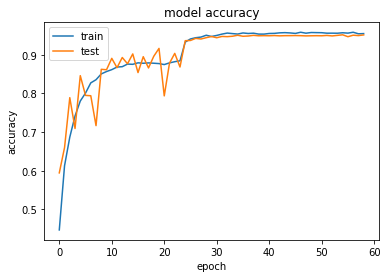

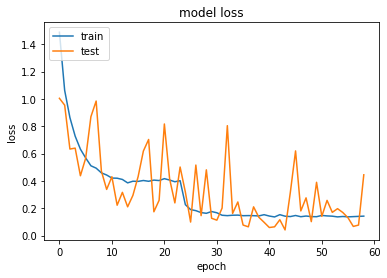

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Comparison of M_MS and M9 model by class and overall. The HerbaceousVegetation class saw the largest improvement, 10 percentage points overall.

In [0]:
M_MS_pred_df = eval_model_by_class(M_MS, X_test)

M9_M_MS_pred_df = M9_pred_df.loc[:, ['y_true', 'label_count']]
M9_M_MS_pred_df['M9_class_acc'] = M9_pred_df.loc[:, 'class_acc']
M9_M_MS_pred_df['M9_overall_acc'] = M9_pred_df.loc[:, 'overall_acc']
M9_M_MS_pred_df['M_MS_class_acc'] = M_MS_pred_df.loc[:, 'class_acc']
M9_M_MS_pred_df['M_MS_overall_acc'] = M_MS_pred_df.loc[:, 'overall_acc']
M9_M_MS_pred_df['M_MS_class_change'] = M9_M_MS_pred_df.loc[:, 'M_MS_class_acc'] - M9_M_MS_pred_df.loc[:, 'M9_class_acc']
M9_M_MS_pred_df['M_MS_overall_change'] = M9_M_MS_pred_df['M_MS_overall_acc'] - M9_M_MS_pred_df['M9_overall_acc'] 

M9_M_MS_pred_df

,y_true,label_count,M9_class_acc,M9_overall_acc,M_MS_class_acc,M_MS_overall_acc,M_MS_class_change,M_MS_overall_change
0,b'AnnualCrop',1500,0.870667,0.912444,0.9360,0.948815,0.065333,0.03637
1,b'Forest',1500,0.978667,0.912444,0.9680,0.948815,-0.010667,0.03637
2,b'HerbaceousVegetation',1500,0.828667,0.912444,0.9360,0.948815,0.107333,0.03637
3,b'Highway',1250,0.868000,0.912444,0.9232,0.948815,0.055200,0.03637
4,b'Industrial',1250,0.958400,0.912444,0.9856,0.948815,0.027200,0.03637
5,b'Pasture',1000,0.917000,0.912444,0.9090,0.948815,-0.008000,0.03637
6,b'PermanentCrop',1250,0.837600,0.912444,0.9112,0.948815,0.073600,0.03637
7,b'Residential',1500,0.986000,0.912444,0.9420,0.948815,-0.044000,0.03637
8,b'River',1250,0.903200,0.912444,0.9688,0.948815,0.065600,0.03637
9,b'SeaLake',1500,0.964000,0.912444,0.9940,0.948815,0.030000,0.03637


Try VGG16 again

In [0]:
# This function lets me change the input shape for VGG16
# Source: https://medium.com/@ckyrkou/changing-input-size-of-pre-trained-models-in-keras-3dfbe3ca3091

def change_model(model, new_input_shape=(None, 40, 40, 3)):
    # replace input shape of first layer
    model._layers[0].batch_input_shape = new_input_shape

    # rebuild model architecture by exporting and importing via json
    new_model = keras.models.model_from_json(model.to_json())

    # copy weights from old model to new one
    for layer in new_model.layers:
        try:
            layer.set_weights(model.get_layer(name=layer.name).get_weights())
            print("Loaded layer {}".format(layer.name))
        except:
            print("Could not transfer weights for layer {}".format(layer.name))

    return new_model

In [0]:
conv_base_MS = change_model(conv_base, new_input_shape = (None, 64, 64, 13))
conv_base_MS.summary()

Loaded layer input_3
Could not transfer weights for layer block1_conv1
Loaded layer block1_conv2
Loaded layer block1_pool
Loaded layer block2_conv1
Loaded layer block2_conv2
Loaded layer block2_pool
Loaded layer block3_conv1
Loaded layer block3_conv2
Loaded layer block3_conv3
Loaded layer block3_pool
Loaded layer block4_conv1
Loaded layer block4_conv2
Loaded layer block4_conv3
Loaded layer block4_pool
Loaded layer block5_conv1
Loaded layer block5_conv2
Loaded layer block5_conv3
Loaded layer block5_pool
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         (None, 64, 64, 13)        0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 64, 64, 64)        7552      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 64, 64, 64)        36928     
_______________

In [0]:
# freeze the weights
for layer in conv_base_MS.layers:
  layer.trainable = False

In [0]:
len(conv_base_MS.trainable_weights)

0

In [0]:
# unfreeze the latter 2/3ds of the base
for layer in conv_base_MS.layers[7:]:
  layer.trainable = True

In [0]:
len(conv_base_MS.trainable_weights)

18

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M2_MS.h5'

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 15, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [0]:
optimizer = RMSprop(lr = 1e-4)
lr_metric = get_lr_metric(optimizer)

In [0]:
M2_MS = Sequential()

M2_MS.add(conv_base_MS)

M2_MS.add(Flatten())
M2_MS.add(Dropout(0.5))
M2_MS.add(Dense(512, activation='relu'))
M2_MS.add(Dense(num_classes, activation='softmax'))

M2_MS.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
history = M2_MS.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size,
                 epochs = epochs,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size,
                 callbacks = callback_list)

Epoch 1/100
210/210 [==============================] - 51s 242ms/step - loss: 1.5408 - accuracy: 0.4477 - lr: 1.0000e-04 - val_loss: 1.2429 - val_accuracy: 0.6010 - val_lr: 1.0000e-04
Epoch 2/100
210/210 [==============================] - 51s 241ms/step - loss: 0.9537 - accuracy: 0.6652 - lr: 1.0000e-04 - val_loss: 1.0580 - val_accuracy: 0.6244 - val_lr: 1.0000e-04
Epoch 3/100
210/210 [==============================] - 50s 240ms/step - loss: 0.7642 - accuracy: 0.7285 - lr: 1.0000e-04 - val_loss: 0.5377 - val_accuracy: 0.7918 - val_lr: 1.0000e-04
Epoch 4/100
210/210 [==============================] - 51s 244ms/step - loss: 0.6791 - accuracy: 0.7688 - lr: 1.0000e-04 - val_loss: 0.8117 - val_accuracy: 0.7464 - val_lr: 1.0000e-04
Epoch 5/100
210/210 [==============================] - 50s 238ms/step - loss: 0.6064 - accuracy: 0.7940 - lr: 1.0000e-04 - val_loss: 0.3770 - val_accuracy: 0.8357 - val_lr: 1.0000e-04
Epoch 6/100
210/210 [==============================] - 50s 238ms/step - loss: 0.

In [0]:
score = M2_MS.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.23358454451296065
Test accuracy: 0.9232592582702637


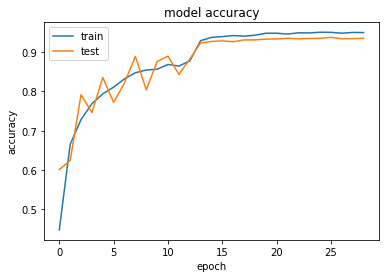

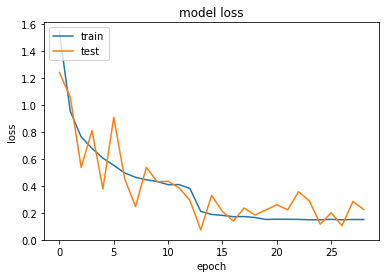

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M2_MS_pred_df = eval_model_by_class(M2_MS, X_test)
M2_MS_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',1399.0,1500,0.932667,0.923259
1,1,b'Forest',1413.0,1500,0.942000,0.923259
2,2,b'HerbaceousVegetation',1280.0,1500,0.853333,0.923259
3,3,b'Highway',1047.0,1250,0.837600,0.923259
4,4,b'Industrial',1214.0,1250,0.971200,0.923259
5,5,b'Pasture',896.0,1000,0.896000,0.923259
6,6,b'PermanentCrop',1050.0,1250,0.840000,0.923259
7,7,b'Residential',1459.0,1500,0.972667,0.923259
8,8,b'River',1214.0,1250,0.971200,0.923259
9,9,b'SeaLake',1492.0,1500,0.994667,0.923259


Retrain VGG16 from scratch

In [0]:
# unfreeze the entire base (i.e., retrain VGG16 from scratch)
for layer in conv_base_MS.layers:
  layer.trainable = True

len(conv_base_MS.trainable_weights)

26

In [0]:
model_file = '/content/drive/My Drive/Colab Notebooks/Remote Sensing/Homeworks/HW 5/Models/M3_MS.h5'

early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', # what is the metric to measure
                              patience = 50, # how many epochs to continue running the model after seeing an increase in val_loss
                              restore_best_weights = True) # update the model with the best-seen weights?

reduce_LR = keras.callbacks.ReduceLROnPlateau(monitor = 'val_loss',
                                              factor = 0.1,
                                              patience = 5) # to make sure early_stop is what stops the model

checkpoint = keras.callbacks.ModelCheckpoint(filepath = model_file,
                                             monitor = 'val_loss',
                                             save_best_only = True)

callback_list = [reduce_LR, early_stop, checkpoint]

In [0]:
optimizer = RMSprop()
lr_metric = get_lr_metric(optimizer)

In [0]:
M3_MS = Sequential()

M3_MS.add(conv_base_MS)

M3_MS.add(Flatten())
M3_MS.add(Dropout(0.5))
M3_MS.add(Dense(512, activation='relu'))
M3_MS.add(Dense(num_classes, activation='softmax'))

M3_MS.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy', lr_metric])

In [0]:
history = M3_MS.fit_generator(train_generator,
                 steps_per_epoch = len(X_train) // batch_size,
                 epochs = 300,
                 validation_data = test_generator,
                 validation_steps = len(X_test) // batch_size,
                 callbacks = callback_list)

Epoch 1/300
210/210 [==============================] - 50s 240ms/step - loss: 1.2585 - accuracy: 0.6045 - lr: 0.0010 - val_loss: 1.2718 - val_accuracy: 0.6810 - val_lr: 0.0010
Epoch 2/300
210/210 [==============================] - 51s 241ms/step - loss: 0.9802 - accuracy: 0.6952 - lr: 0.0010 - val_loss: 1.5256 - val_accuracy: 0.6269 - val_lr: 0.0010
Epoch 3/300
210/210 [==============================] - 50s 240ms/step - loss: 0.9347 - accuracy: 0.7032 - lr: 0.0010 - val_loss: 0.8707 - val_accuracy: 0.5985 - val_lr: 0.0010
Epoch 4/300
210/210 [==============================] - 50s 239ms/step - loss: 0.9681 - accuracy: 0.7007 - lr: 0.0010 - val_loss: 0.7593 - val_accuracy: 0.7868 - val_lr: 0.0010
Epoch 5/300
210/210 [==============================] - 50s 238ms/step - loss: 0.9128 - accuracy: 0.7158 - lr: 0.0010 - val_loss: 0.8540 - val_accuracy: 0.6621 - val_lr: 0.0010
Epoch 6/300
210/210 [==============================] - 50s 238ms/step - loss: 0.8518 - accuracy: 0.7293 - lr: 0.0010 - v

In [0]:
score = M3_MS.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.2965094121473807
Test accuracy: 0.9194074273109436


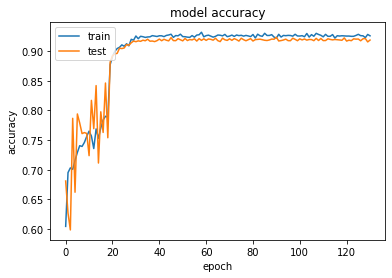

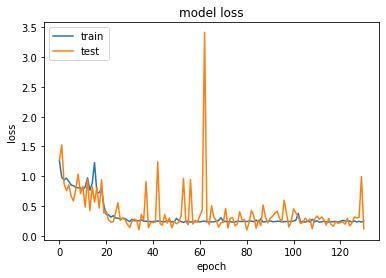

In [0]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [0]:
M3_MS_pred_df = eval_model_by_class(M3_MS, X_test)
M3_MS_pred_df

,index,y_true,accurate_preds,label_count,class_acc,overall_acc
0,0,b'AnnualCrop',1298.0,1500,0.865333,0.919407
1,1,b'Forest',1440.0,1500,0.960000,0.919407
2,2,b'HerbaceousVegetation',1333.0,1500,0.888667,0.919407
3,3,b'Highway',1126.0,1250,0.900800,0.919407
4,4,b'Industrial',1195.0,1250,0.956000,0.919407
5,5,b'Pasture',861.0,1000,0.861000,0.919407
6,6,b'PermanentCrop',1039.0,1250,0.831200,0.919407
7,7,b'Residential',1427.0,1500,0.951333,0.919407
8,8,b'River',1200.0,1250,0.960000,0.919407
9,9,b'SeaLake',1493.0,1500,0.995333,0.919407
